In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [20]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')

In [21]:
data = pd.merge(transactions, customers, on='CustomerID')
data = pd.merge(data, products, on='ProductID')

In [22]:
data.fillna(0, inplace=True)

In [23]:
customer_features = data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),  # Total amount spent by the customer
    purchase_frequency=('TransactionID', 'count'),  # Number of transactions
    unique_products=('ProductID', 'nunique')  # Number of unique products purchased
).reset_index()

In [24]:
customer_features = pd.merge(customer_features, customers[['CustomerID', 'Region']], on='CustomerID')

In [25]:
encoder = OneHotEncoder(sparse_output = False)
region_encoded = encoder.fit_transform(customer_features[['Region']])

In [26]:
region_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Region']))
region_df['CustomerID'] = customer_features['CustomerID']

In [27]:
customer_features = pd.merge(customer_features, region_df, on='CustomerID')

In [28]:
numeric_columns = ['total_spent', 'purchase_frequency', 'unique_products'] + list(region_df.columns)
numeric_data = customer_features[numeric_columns]

In [30]:
scaler = StandardScaler()
numeric_data = numeric_data.apply(pd.to_numeric, errors='coerce')
numeric_data.fillna(0, inplace=True) 
numeric_data_scaled = scaler.fit_transform(numeric_data)
db_index_scores = []

In [32]:
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(numeric_data_scaled)
    labels = kmeans.labels_
    db_index = davies_bouldin_score(numeric_data_scaled, labels)
    db_index_scores.append(db_index)
    customer_features[f'Cluster_{n_clusters}'] = labels


In [33]:
optimal_clusters = np.argmin(db_index_scores) + 2
print(f"Optimal number of clusters: {optimal_clusters}")

Optimal number of clusters: 9


In [34]:
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
final_kmeans.fit(numeric_data_scaled)
customer_features['Cluster'] = final_kmeans.labels_

In [35]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numeric_data_scaled)

In [36]:
customer_features['PCA1'] = pca_result[:, 0]
customer_features['PCA2'] = pca_result[:, 1]

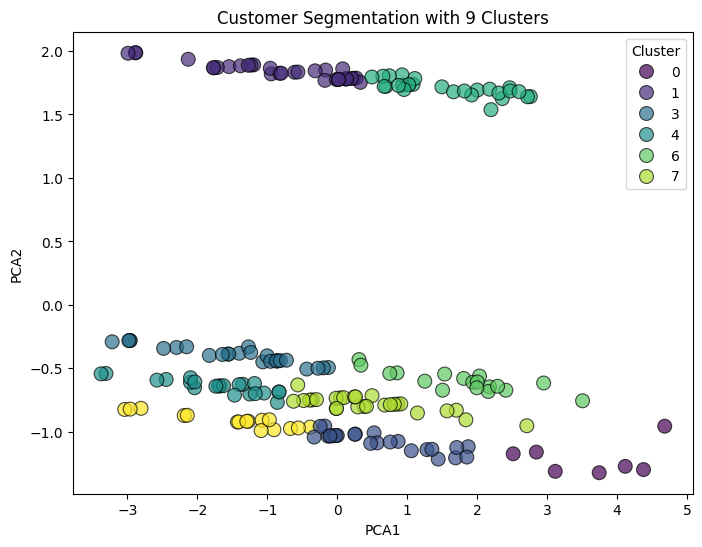

In [37]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_features, palette='viridis', s=100, alpha=0.7, edgecolor='k')
plt.title(f"Customer Segmentation with {optimal_clusters} Clusters")
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title="Cluster")
plt.show()


In [38]:
for n_clusters, db_index in zip(range(2, 11), db_index_scores):
    print(f"DB Index for {n_clusters} clusters: {db_index}")

DB Index for 2 clusters: 1.6782872540642975
DB Index for 3 clusters: 1.583845652404334
DB Index for 4 clusters: 1.2141936478852136
DB Index for 5 clusters: 0.8232989268224286
DB Index for 6 clusters: 0.7737320614922556
DB Index for 7 clusters: 0.7505758717828359
DB Index for 8 clusters: 0.7144688430775477
DB Index for 9 clusters: 0.7089198980815448
DB Index for 10 clusters: 0.7166575293066874
